In [1]:
# %%capture
# !pip install tensorflow==2.10.0

In [2]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import random
import tensorflow as tf
from keras import models, layers
from keras import backend
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc
import psutil
import time

# import numpy as np

In [3]:
mySeed = 42
# np.random.seed(mySeed)
random.seed(mySeed)
tf.random.set_seed(mySeed)
# torch.manual_seed(mySeed)

In [4]:
def get_memory_usage():
    memory_info = psutil.virtual_memory()
    memory_percent = memory_info.percent
    # memory_free_values = memory_info.available / (1024**3)  # in GB
    return memory_percent

In [5]:
# Hyper parameters

num_clients = 5
batch_size = 8
total_steps = 20

clear_memory_in_percent = 80
is_print_eval = False

lr = 0.01
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr/total_steps)
optimizer = "adam"
loss_cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = ["accuracy"]
client_epochs = 1

swap_step = 2
n_swap_between_avg = 2 # plus one to your number, if need 2 swap between avg, enter 3

## Load Data

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train, x_test = x_train/255, x_test/255

# OneHotEncoded Labels
oneHotEncoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
y_train = oneHotEncoder.fit_transform(y_train.reshape(-1, 1))
y_test = oneHotEncoder.transform(y_test.reshape(-1, 1))

print(f"Train x={x_train.shape}, y={y_train.shape}")
print(f"Test x={x_test.shape}, y={y_test.shape}")

Train x=(60000, 28, 28), y=(60000, 10)
Test x=(10000, 28, 28), y=(10000, 10)


In [7]:
# Remove one dimension for data
x_train = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])

print(f"Train x={x_train.shape}, y={y_train.shape}")
print(f"Test x={x_test.shape}, y={y_test.shape}")

Train x=(60000, 784), y=(60000, 10)
Test x=(10000, 784), y=(10000, 10)


In [8]:
# Remove some data for running faster in test
remain = 0.01

x_train = x_train[:int(x_train.shape[0]*remain)]
y_train = y_train[:int(y_train.shape[0]*remain)]
x_test = x_test[:int(x_test.shape[0]*remain)]
y_test = y_test[:int(y_test.shape[0]*remain)]

print(f"Train x={x_train.shape}, y={y_train.shape}")
print(f"Test x={x_test.shape}, y={y_test.shape}")

Train x=(600, 784), y=(600, 10)
Test x=(100, 784), y=(100, 10)


In [9]:
def create_clients_with_data_assignment(values_list, label_list, num_clients=10, initial="client"):
    """ return: A dictionary with the customer id as the dictionary key and the value
                will be the data fragment - tuple of values and labels.
        args:
            values_list: a numpy array object with the values
            label_list: list of binarized labels (one-hot encoded)
            num_clients: number of customers (clients)
            initial: the prefix of the clients, e.g., client_1
     """

    # create list of client names
    client_names = [f"{initial}_{i+1}" for i in range(num_clients)]

    # shuffle the data
    data = list(zip(values_list, label_list))
    random.shuffle(data)

    # shard the data and split it for each customer
    size = len(data) // num_clients
    shards = [data[i: i+size]  for i in range(0, size*num_clients, size)]

    # Check if the fragment number is equal to the number of clients
    assert(len(shards) == len(client_names))

    return {client_names[i]: shards[i]  for i in range(len(client_names))}

In [10]:
def batch_data(data_shard, batch_size=32):
    """ Receives a piece of data (values, labels) from a client and creates a tensorflow Dataset object in it
        args:
            data_shard: values and labels that make up a customer's data shard
            batch_size: batch size
        return:
            data tensorflow Dataset object
    """
    #seperate shard into data and labels lists
    values, labels = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(values), list(labels)))
    return dataset.shuffle(len(labels), reshuffle_each_iteration=False).batch(batch_size)


### Explaining the function with example ###
# test = list(zip([[1, 2], [3, 4], [5, 6], [7, 8]], ["a", "b", "c", "d"]))
# print(test)
# data, label = zip(*test)
# print(data)
# print(label)

# dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
# test1 = dataset.shuffle(len(label))
# print(list(test1.as_numpy_iterator()))
# test2 = dataset.shuffle(len(label)).batch(3)
# print(list(test2.as_numpy_iterator()))
# list(test2)[0][0].shape

In [11]:
# Create clients and batched data

clients = create_clients_with_data_assignment(x_train, y_train, num_clients=num_clients, initial="client")

# Bached data with tensorflow data object
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data, batch_size)

test_batch_size = len(y_test)
# Convert test data to tensorflow data object
test_batched = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(test_batch_size)

## Training

In [12]:
def scale_model_weights(weight, scalar):
    """ Scale the model weights """

    weight_final = []
    for i in range(len(weight)):
        weight_final.append(weight[i] * scalar)

    return weight_final

In [13]:
def sum_scaled_weights(scaled_weight_list):
    """ Return the sum of the listed scaled weights.
        axis_O is equivalent to the average weight of the weights """

    avg_weights = list()
    # get the average gradient accross all client gradients
    for gradient_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(gradient_list_tuple, axis=0)
        avg_weights.append(layer_mean)

    return avg_weights


### Explaining the function with example ###
# t = [[[[2, 3],[3, 4]], [[3, 4],[4, 5]], [[4, 5],[5, 6]]],
#      [[[5, 6],[6, 7]], [[6, 7],[7, 8]], [[7, 8],[8, 9]]]]
# for y in zip(*t):
#     print(y)
#     print(tf.math.reduce_sum(y, axis=0))

In [14]:
def test_global_model(x_test, y_test, model, loss_func):
    y_pred = model.predict(x_test, verbose=0)
    loss = loss_func(y_test, y_pred)

    acc = accuracy_score(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))

    return acc, loss.numpy()

In [15]:
class MLP:
    @staticmethod
    def build(shape, classes):
        model = models.Sequential([
            layers.Dense(100, activation="relu", input_shape=shape),
            layers.Dense(99, activation="relu"),
            layers.Dense(classes, activation="softmax"),
            ])

        return model

In [16]:
# Initialize all clients with same weight
global_history = {"accuracy":list(), "loss":list()}
mlp_global = MLP()
global_model = mlp_global.build(x_train.shape[1:], y_train.shape[-1])
global_weights = global_model.get_weights()

client_select = list(clients_batched.keys())
client_weights = dict.fromkeys(client_select, global_weights)

In [17]:
def fed_swap(client):
    random_num = random.randint(0, len(client_select)-1)
    random_client = client_select[random_num]

    temp_weight = client_weights[random_client]
    client_weights[random_client] = client_weights[client]

    return temp_weight

In [18]:
def fed_avg():
    # calculate total training data across clients
    # if all clients have a same length
    local_count = len(clients[client_select[0]])
    global_count = local_count * len(client_select)
    scaling_factor = local_count / global_count

    # initial list to collect clients weight after scalling
    scaled_clients_weight_list = list()
    
    for client in client_select:
        scaled_weights = scale_model_weights(client_weights[client], scaling_factor)
        scaled_clients_weight_list.append(scaled_weights)

    # to get the average over all the clients model, we simply take the sum of the scaled weights
    avg_weights = sum_scaled_weights(scaled_clients_weight_list)

    return avg_weights

In [19]:
def print_log(training_time, swapping_time, step_time, step):
    print(f"round: {step} | training_time: {training_time:.2f}s | swapping_time: {swapping_time:.2f}s | step_time: {step_time:.2f}s")

    global is_print_eval
    if is_print_eval:
        is_print_eval = False
        print(f"round: {step} / global_acc: {global_history['accuracy'][-1]:.4%} / global_loss: {global_history['loss'][-1]:.4f}\n")

In [20]:
for step in range(total_steps):
    training_time_start = time.time()
    for client in client_select:
        mlp_local = MLP()
        local_model = mlp_local.build(x_train.shape[1:], y_train.shape[-1])
        local_model.compile(optimizer=optimizer, loss=loss_cce, metrics=metrics)

        local_model.set_weights(client_weights[client])
        local_model.fit(clients_batched[client], epochs=client_epochs, verbose=0)
        client_weights[client] = local_model.get_weights()

        backend.clear_session()
        del mlp_local
        del local_model

        if get_memory_usage() > clear_memory_in_percent:
            gc.collect()
    
    training_time = time.time() - training_time_start

    swapping_time_start = time.time()
    if (step % swap_step == 0) and (step % (swap_step*n_swap_between_avg) != 0):
        for client in client_select:
            client_weights[client] = fed_swap(client)
    
    swapping_time = time.time() - swapping_time_start

    if (step % (swap_step*n_swap_between_avg) == 0):
        avg_weights = fed_avg()
        client_weights = dict.fromkeys(client_select, avg_weights)

        # update global model
        global_model.set_weights(avg_weights)

        is_print_eval = True
        # test global model and print out metrics after each ...... round
        for (x_test, y_test) in test_batched:
            global_acc, global_loss = test_global_model(x_test, y_test, global_model, loss_cce)
            global_history["accuracy"].append(global_acc)
            global_history["loss"].append(global_loss)

    step_time = time.time() - training_time_start
    print_log(training_time, swapping_time, step_time, step)

round: 0 | training_time: 12.74s | swapping_time: 0.00s | step_time: 13.34s
round: 0 / global_acc: 49.0000% / global_loss: 2.0102

round: 1 | training_time: 14.17s | swapping_time: 0.00s | step_time: 14.17s
round: 2 | training_time: 13.73s | swapping_time: 0.00s | step_time: 13.73s
round: 3 | training_time: 15.77s | swapping_time: 0.00s | step_time: 15.77s
round: 4 | training_time: 14.26s | swapping_time: 0.00s | step_time: 15.14s
round: 4 / global_acc: 76.0000% / global_loss: 0.7789

round: 5 | training_time: 17.64s | swapping_time: 0.00s | step_time: 17.64s
round: 6 | training_time: 11.14s | swapping_time: 0.00s | step_time: 11.14s
round: 7 | training_time: 12.90s | swapping_time: 0.00s | step_time: 12.90s
round: 8 | training_time: 12.07s | swapping_time: 0.00s | step_time: 12.86s
round: 8 / global_acc: 82.0000% / global_loss: 0.5845

round: 9 | training_time: 12.75s | swapping_time: 0.00s | step_time: 12.75s
round: 10 | training_time: 13.38s | swapping_time: 0.00s | step_time: 13.38

## Result

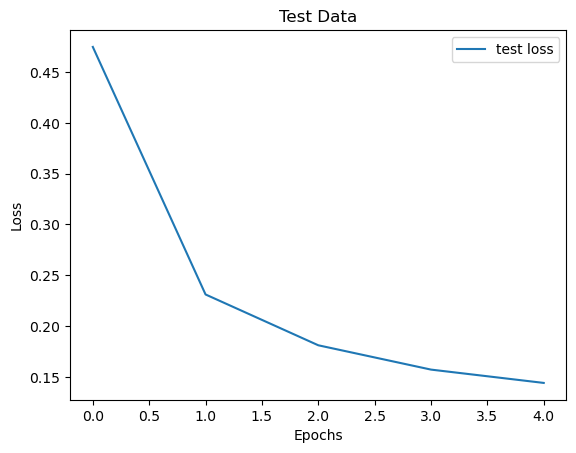

In [ ]:
plt.plot(global_history["loss"], label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Data")
plt.legend()
plt.show()

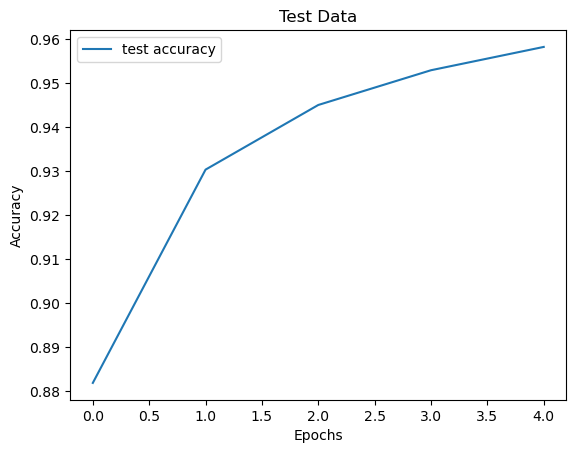

In [ ]:
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()

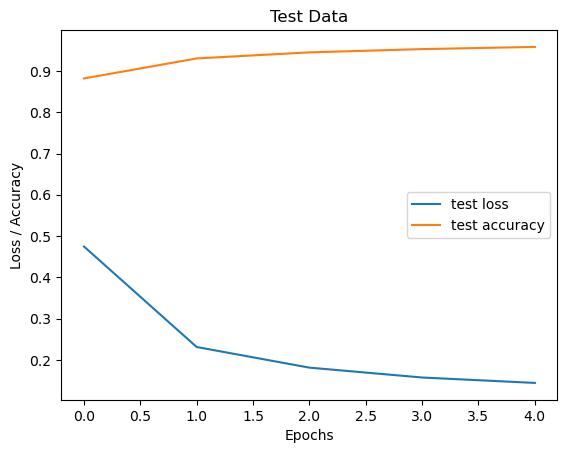

In [ ]:
plt.plot(global_history["loss"], label="test loss")
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()